# 2 Собираем датасет транзакций

## Состав сета

Сет транзакций будет состоять из:
- исходного сета с транзакциями клиентов
- разметки гендера по транзакциям 
- справочника MCC
- справочника типов транзакций

Для начала обработаем справочники, так как в них может содержаться информация, которую можно превратить в полезные фичи.

## Выделяем фичи справочников

### Справочник MCC

In [1]:
import pandas as pd
pd.set_option('max_colwidth', 400)

In [2]:
tr_mcc_codes = pd.read_csv('kaggle_datasets/tr_mcc_codes.csv', delimiter=';')
tr_mcc_codes.sample(7, random_state=7)

,mcc_code,mcc_description
182,9399,"Правительственные услуги, нигде ранее не классифицируемые"
179,9211,"Судовые выплаты, включая алименты и детскую поддержку"
131,7011,"Отели, мотели, базы отдыха, сервисы бронирования"
24,4900,"Коммунальные услуги — электричество, газ, санитария, вода"
65,5541,Станции техобслуживания
104,5947,"Магазины открыток, подарков, новинок и сувениров"
32,5074,Оборудование для водопровода и отопительной системы


**Что мы видим**

1. **Ключом справочника является [MCC код](https://ru.wikipedia.org/wiki/Merchant_Category_Code)**. 

Это международный справочник, в котором перечислены значения отраслей и категорий точек продаж. Последние две цифры кода - категория, а первые 1-2 символа - отрасль.

2.  **Описание категории сложносоставное.** 

Необходимо его упростить. Выделим из названия основу (до знаков запятой, тире и слэша) и отдельно выделим макроотрасль MCC (первые две цифиы ).

In [3]:
# сохраним текущее значение описания в отдельном поле
tr_mcc_codes['mcc_full_description'] = tr_mcc_codes['mcc_description']

In [4]:
# сформируем описание МСС для дальнейшей работы с ним

## подготовим функцию, выделяющую первую часть значения (до разделителя)
def extract_text_before_delimiter(value):
    delimiters = [',', '—', '/']
    for delimiter in delimiters:
        if delimiter in value:
            value = value.split(delimiter)[0].strip()
    return value

## пройдемся по всем строкам функцией, выделяющей текст до разделителя
for index, row in tr_mcc_codes.iterrows():
    tr_mcc_codes.at[index, 'mcc_description'] = extract_text_before_delimiter(row['mcc_description'])

## добавим к сокращенному описанию значение кода MCC, чтобы исключить дубликаты в этом поле
tr_mcc_codes['mcc_description'] = tr_mcc_codes['mcc_description'] + ' (' + tr_mcc_codes['mcc_code'].astype('str') + ')' 

In [5]:
# выделяем группу MCC отдельной фичей
tr_mcc_codes['mcc_group'] = tr_mcc_codes['mcc_code'].astype('str').apply(lambda x: x[:2])

In [6]:
# сохраним получившийся справочник отдельным файлом
import os
os.makedirs('./datasets', exist_ok=True) # создадим папку для сохранения

tr_mcc_codes.to_csv('datasets/tr_mcc_codes_featured.csv', index=False)
tr_mcc_codes.head(5)

,mcc_code,mcc_description,mcc_full_description,mcc_group
0,742,Ветеринарные услуги (742),Ветеринарные услуги,74
1,1711,Генеральные подрядчики по вентиляции (1711),"Генеральные подрядчики по вентиляции, теплоснабжению, и водопроводу",17
2,1731,Подрядчики по электричеству (1731),Подрядчики по электричеству,17
3,1799,Подрядчики (1799),"Подрядчики, специализированная торговля — нигде более не классифицированные",17
4,2741,Разнообразные издательства (2741),Разнообразные издательства/печатное дело,27


Справочник MCC готов

### Справочник типов категорий

In [7]:
tr_types = pd.read_csv('kaggle_datasets/tr_types.csv', delimiter=';')
tr_types.sample(7, random_state=7)

,tr_type,tr_description
90,3810,н/д
76,8140,Операции по утраченной карте
37,6210,Возврат покупки.POS Зарубеж. ТУ
11,4040,Плата за взнос наличных через POS (в своем тер.банке)
70,8001,Установление расх. лимита по
146,2432,Перевод с карты на счет физ.лица в другом банке через Сбербанк ОнЛ@йн
118,2330,Списание с карты по операции “перевода с карты на карту” через АТМ (в пределах одного тер.банка)



Номер типа операции является внутренним справочником Сбера. Он нам многого не дает.

В описании типа транзакции находится множество информации. Достанем из описания ключевые параметра типа транзакции:
- **устройство**, в котором она была произведена (банкомат, интернет-банк, смс-банк или филиал)
- является ли транзакция операцией **с наличными**, комиссией за использование наличных или безналичная операция
- **регион** операции (зарубежная или российская операция) и банк (домашний банк или "роуминг")
- собственно **тип операции** исходя из названия

In [8]:
device_type_map = {
    'АТМ'                                       : 'АТМ',
    'Банкомат'                                  : 'ATM',
    'через УС'                                  : 'ATM',
    'POS'                                       : 'POS',
    'ТУ'                                        : 'POS',
    'через Мобильный банк'                      : 'SMS',
    'посредством мобильной связи'               : 'mobile',
    'ВСП'                                       : 'VSP',
    'в подразд'                                 : 'VSP',
    'Сбербанк ОнЛ@йн'                           : 'SBOL',
    'через Интернет'                            : 'SBOL',
    'автомат'                                   : 'auto',
}


cash_type_map = {
    'Плата за получение наличных'               : 'cash_trx_payment',
    'Плата за взнос наличных'                   : 'cash_trx_payment',
    'экстренной выдачи наличных'                : 'cash_trx_payment',
    'Взнос наличных'                            : 'cash_trx',
    'Выдача наличных'                           : 'cash_trx',
}


region_map = {
    'Зарубеж'                                   : 'foreign_trx',
    'Россия'                                    : 'other_bank_trx',
    'в чужом АТМ'                               : 'other_bank_trx',
    'из одного ТБ в другой ТБ'                  : 'sberbank_trx',
    'СБ РФ'                                     : 'sberbank_trx',
    'АТМ Сбербанка'                             : 'sberbank_trx',
    'Сбербанк'                                  : 'home_terbank_trx',
    'в своем тер.банке'                         : 'home_terbank_trx',
    'в пределах одного тер.банка'               : 'home_terbank_trx',
    'в своем ТБ'                                : 'home_terbank_trx',
    'в пределах одного филиала'                 : 'home_terbank_trx',
    'в других ТБ'                               : 'other_terbank_trx',
    'в другом тер.банк'                         : 'other_terbank_trx',
}


trx_type_map = {
    'Возврат'                                   : 'Возврат',
    'Перевод'                                   : 'B2C перевод',
    'перевод'                                   : 'B2C перевод',
    'Плата за'                                  : 'Комиссия',
    'Взнос наличных'                            : 'Взнос наличных',
    'Оплата услуг банка'                        : 'Комиссия',
    'Покупка'                                   : 'POS покупка',
    'Пополнение счета'                          : 'Пополнение',
    'Платеж с карты '                           : 'Платеж',
    'Оплата услуги'                             : 'Платеж',
    'Выдача наличных'                           : 'Выдача наличных',
    'Погашение кредита'                         : 'Погашение кредита',
    'Наличные'                                  : 'Выдача наличных',
    'Списание'                                  : 'Списание',
    'списание'                                  : 'Списание',
    'Списание с карты по операции “перевода'    : 'B2C перевод',
    'Комиссия'                                  : 'Комиссия',
    'пополнения зарплатных '                    : 'Заработная плата',
    'перечисления процентов'                    : 'Начисление процентов',
}




def dict_enrichment(dict, field, default_val):
    """
    Проверяет в каждом поле справочника наличие значения `text` и
     подставляет в поле `field` значение из маппера `dict`
    """

    tr_types[field] = pd.Series().astype('object')
    # вызвано https://pandas.pydata.org/docs/whatsnew/v2.1.0.html#deprecated-silent-upcasting-in-setitem-like-series-operations

    for text in dict:
        tr_types.loc[tr_types['tr_description'].str.contains(text), field] = dict[text]
    tr_types[field] = tr_types[field].fillna(default_val)


dict_enrichment(device_type_map,    'device',           'unknown')
dict_enrichment(cash_type_map,      'cash_relation',    'unrelated')
dict_enrichment(region_map,         'region',           'unrelated')
dict_enrichment(trx_type_map,       'type',             'other')

tr_types.to_csv('datasets/tr_types_featured.csv', index=False)
tr_types.sample(5, random_state=11)


# кстати, эту обработку можно было бы переработать, сделав мапперы со структурой, типа:
# 
# trx_type_map = {
#     field : 'region', 
#     maps: {
#         'home_terbank_trx': [
#             'Сбербанк',
#             'в своем тер.банке',
#             'в пределах одного тер.банка',
#             'в своем ТБ',
#             'в пределах одного филиала'
#         ]
#     }
# }
# 
# Делать мы этого, конечно, не будем.
# 
# Потому что читаемость сейчас низкая, но достаточная и далее переиспользуемости этого маппинга не будет. 


# Также можно было бы поработать с номерами типов операций из справочников сбера, 
# так как они могли бы дать определенные данные по группе типа транзакций и самой транзакции.
# Но кажется, что описание нам дает больше информации по объему.

,tr_type,tr_description,device,cash_relation,region,type
119,2331,Списание с карты по операции “перевода с карты на карту” через АТМ (из одного ТБ в другой ТБ),АТМ,unrelated,sberbank_trx,B2C перевод
137,2412,Перевод с карты на счет др.лица в одном тер. банке через Сбербанк ОнЛ@йн,SBOL,unrelated,home_terbank_trx,B2C перевод
126,2352,Погашение кредита с карты через АТМ,АТМ,unrelated,unrelated,Погашение кредита
65,7090,Межфилиальные пополнения зарплатных карт,unknown,unrelated,unrelated,Заработная плата
88,2440,н/д,unknown,unrelated,unrelated,other


Справочники готовы. Приступаем к слиянию данных в общую таблицу.

## Формирование общего датасета транзакций

### Слияние данных

Сольем данные всех файлов в один сет.

In [9]:
# открываем файлы
transactions = pd.read_csv('kaggle_datasets/transactions.csv.zip', delimiter=',')
gender_train = pd.read_csv('kaggle_datasets/gender_train.csv', delimiter=',')

# сливаем файлы
rawset = pd.merge(transactions, gender_train, on='customer_id', how='left')
rawset = pd.merge(rawset, tr_types, on='tr_type', how='left')
rawset = pd.merge(rawset, tr_mcc_codes, on='mcc_code', how='left')

In [10]:
rawset.sample(5, random_state=11)

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,gender,tr_description,device,cash_relation,region,type,mcc_description,mcc_full_description,mcc_group
4852146,24634142,409 16:39:16,5411,1110,-9515.95,25011898,NaN,Покупка. POS ТУ Россия,POS,unrelated,other_bank_trx,POS покупка,Бакалейные магазины (5411),"Бакалейные магазины, супермаркеты",54
3368757,4891744,372 19:00:02,5411,1010,-875.91,323492,NaN,Покупка. POS ТУ СБ РФ,POS,unrelated,sberbank_trx,POS покупка,Бакалейные магазины (5411),"Бакалейные магазины, супермаркеты",54
6191439,29894123,411 11:01:26,6010,7070,49499.98,888987,NaN,Перевод на карту (с карты) через Мобильный банк (без взимания комиссии с отправителя),SMS,unrelated,unrelated,B2C перевод,Финансовые институты (6010),Финансовые институты — снятие наличности вручную,60
4518851,41783890,453 16:26:28,6010,7070,33688.74,888901,0.0,Перевод на карту (с карты) через Мобильный банк (без взимания комиссии с отправителя),SMS,unrelated,unrelated,B2C перевод,Финансовые институты (6010),Финансовые институты — снятие наличности вручную,60
5414347,56680038,344 09:25:06,5411,1010,-19512.52,689652,1.0,Покупка. POS ТУ СБ РФ,POS,unrelated,sberbank_trx,POS покупка,Бакалейные магазины (5411),"Бакалейные магазины, супермаркеты",54


Для подготовки сета необходимо дополнительно обработать поля времени операций `tr_datetime` и размера `amount`.

Размер операции `amount` будет удобно перевести в абсолютные значения с пометкой - расход это или доход. Это позволит работать с валовыми объемами операций вне зависимости от их направления.

Значение `tr_datetime` необходимо привести к формату даты-времени, желательно с корректной привязкой к временной шкале.

### Обработка поля `amount`

In [11]:
# Добавим абсолютное значение поля как `amount_abs`:
rawset['amount_abs'] = rawset['amount'].apply(abs)

# Добавим направление транзакции, введя поле is_income. Если это входящая тразнакция - ставим 1, если исходящая (расход) - 0.
rawset.loc[rawset['amount']>0, 'is_income'] = 1
rawset.loc[rawset['amount']<0, 'is_income'] = 0

In [12]:
rawset.sample(5, random_state=11)

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,gender,tr_description,device,cash_relation,region,type,mcc_description,mcc_full_description,mcc_group,amount_abs,is_income
4852146,24634142,409 16:39:16,5411,1110,-9515.95,25011898,NaN,Покупка. POS ТУ Россия,POS,unrelated,other_bank_trx,POS покупка,Бакалейные магазины (5411),"Бакалейные магазины, супермаркеты",54,9515.95,0.0
3368757,4891744,372 19:00:02,5411,1010,-875.91,323492,NaN,Покупка. POS ТУ СБ РФ,POS,unrelated,sberbank_trx,POS покупка,Бакалейные магазины (5411),"Бакалейные магазины, супермаркеты",54,875.91,0.0
6191439,29894123,411 11:01:26,6010,7070,49499.98,888987,NaN,Перевод на карту (с карты) через Мобильный банк (без взимания комиссии с отправителя),SMS,unrelated,unrelated,B2C перевод,Финансовые институты (6010),Финансовые институты — снятие наличности вручную,60,49499.98,1.0
4518851,41783890,453 16:26:28,6010,7070,33688.74,888901,0.0,Перевод на карту (с карты) через Мобильный банк (без взимания комиссии с отправителя),SMS,unrelated,unrelated,B2C перевод,Финансовые институты (6010),Финансовые институты — снятие наличности вручную,60,33688.74,1.0
5414347,56680038,344 09:25:06,5411,1010,-19512.52,689652,1.0,Покупка. POS ТУ СБ РФ,POS,unrelated,sberbank_trx,POS покупка,Бакалейные магазины (5411),"Бакалейные магазины, супермаркеты",54,19512.52,0.0


Теперь у нас есть поля `amount_abs` и `is_income`. Это позволит нам удобно собирать общие агрегаты по операциям клиента.

### Обработка поля `tr_datetime`

#### Приведение к формату даты-времени

In [13]:
# Приводим значения поля `tr_datetime` к формату даты-времени. Пишем функцию и пробуем ее запустить.

import datetime
def timeformatter(rawdate):
    # разделяем поле на два значения (разделитель - пробел)
    rows = rawdate.split(' ')
    
    # первое значение преобразуем в дату, второе - в формат времени
    days = datetime.timedelta(days=int(rows[0]))
    time = datetime.datetime.strptime(rows[1], '%H:%M:%S')

    return (days+time)


try:
    rawset['tr_datetime'] = rawset['tr_datetime'].apply(timeformatter)

except ValueError as err:
    print('Ошибка: ', err)

Ошибка:  second must be in 0..59


Судя по ошибке, поле содержит данные со значением секунд большим чем 59. Проверим это

In [14]:
# Функция выдает ошибку, потому что почти 100 000 записей имеют количество секунд больше 59

rawset[rawset['tr_datetime'].apply(lambda x: int(x[-2::]) > 59)]['tr_datetime']

77          43 06:27:60
221        123 07:16:60
233        132 13:24:60
292        154 11:02:60
302        157 11:55:60
               ...     
6848953    115 11:44:60
6848980    143 07:00:60
6849179    359 16:47:60
6849257    420 19:06:60
6849342    454 10:54:60
Name: tr_datetime, Length: 99524, dtype: object

Таких значений почти 100 000. Судя по тому, что визуально они все равны 60, это ошибка округления. 

Приведем значение более 59 секунд к 59 и повторим обработку.

In [15]:
# Исправляем секунды: приводим 60 секунд к значению 59, проверяем есть ли записи со значением секунд больше 59.

def seconds_fixer(string):
    first_part = string[:-2:] # выделяем все до секунд
    last_2chrs = string[-2::] # выделяем секунды

    if int(last_2chrs) > 59:
        last_2chrs = '59'
    
    return (first_part+last_2chrs)

rawset['tr_datetime'] = rawset['tr_datetime'].apply(seconds_fixer)


# Снова пробуем преобразовать строку в формат даты-времени
rawset['tr_datetime'] = rawset['tr_datetime'].apply(timeformatter)


# добавляем отдельно поле даты
rawset['tr_date'] = rawset['tr_datetime'].apply(lambda x: x.date())


In [16]:
rawset.sample(5, random_state=11)

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,gender,tr_description,device,cash_relation,region,type,mcc_description,mcc_full_description,mcc_group,amount_abs,is_income,tr_date
4852146,24634142,1901-02-14 16:39:16,5411,1110,-9515.95,25011898,NaN,Покупка. POS ТУ Россия,POS,unrelated,other_bank_trx,POS покупка,Бакалейные магазины (5411),"Бакалейные магазины, супермаркеты",54,9515.95,0.0,1901-02-14
3368757,4891744,1901-01-08 19:00:02,5411,1010,-875.91,323492,NaN,Покупка. POS ТУ СБ РФ,POS,unrelated,sberbank_trx,POS покупка,Бакалейные магазины (5411),"Бакалейные магазины, супермаркеты",54,875.91,0.0,1901-01-08
6191439,29894123,1901-02-16 11:01:26,6010,7070,49499.98,888987,NaN,Перевод на карту (с карты) через Мобильный банк (без взимания комиссии с отправителя),SMS,unrelated,unrelated,B2C перевод,Финансовые институты (6010),Финансовые институты — снятие наличности вручную,60,49499.98,1.0,1901-02-16
4518851,41783890,1901-03-30 16:26:28,6010,7070,33688.74,888901,0.0,Перевод на карту (с карты) через Мобильный банк (без взимания комиссии с отправителя),SMS,unrelated,unrelated,B2C перевод,Финансовые институты (6010),Финансовые институты — снятие наличности вручную,60,33688.74,1.0,1901-03-30
5414347,56680038,1900-12-11 09:25:06,5411,1010,-19512.52,689652,1.0,Покупка. POS ТУ СБ РФ,POS,unrelated,sberbank_trx,POS покупка,Бакалейные магазины (5411),"Бакалейные магазины, супермаркеты",54,19512.52,0.0,1900-12-11


Мы получили значения `tr_datetime` в корректном формате даты-времени и выделили дату (`tr_date`) для большего удобства.

Попробуем найти истинные значения дат.

#### Привязка к временным координатам

Попробуем найти точное время по специфическим временным отсечкам, например новому году.

Построим график частоты операций по наиболее частой категории, связанной с физическими оплатами в мазинах.

Такая категория должна давать наименьший перекос в данных и давать явную метку начала новогодних праздников и падения количества операций.

In [17]:
rawset['mcc_description'].value_counts().head(5)

mcc_description
Финансовые институты (6011)                 1447370
Финансовые институты (6010)                 1021046
Звонки с использованием телефонов (4814)     987181
Бакалейные магазины (5411)                   961860
Денежные переводы (4829)                     624643
Name: count, dtype: int64

Наиболее частой категорией из офлайновых является категория "Бакалейные магазины". Построим график количества её транзакций.

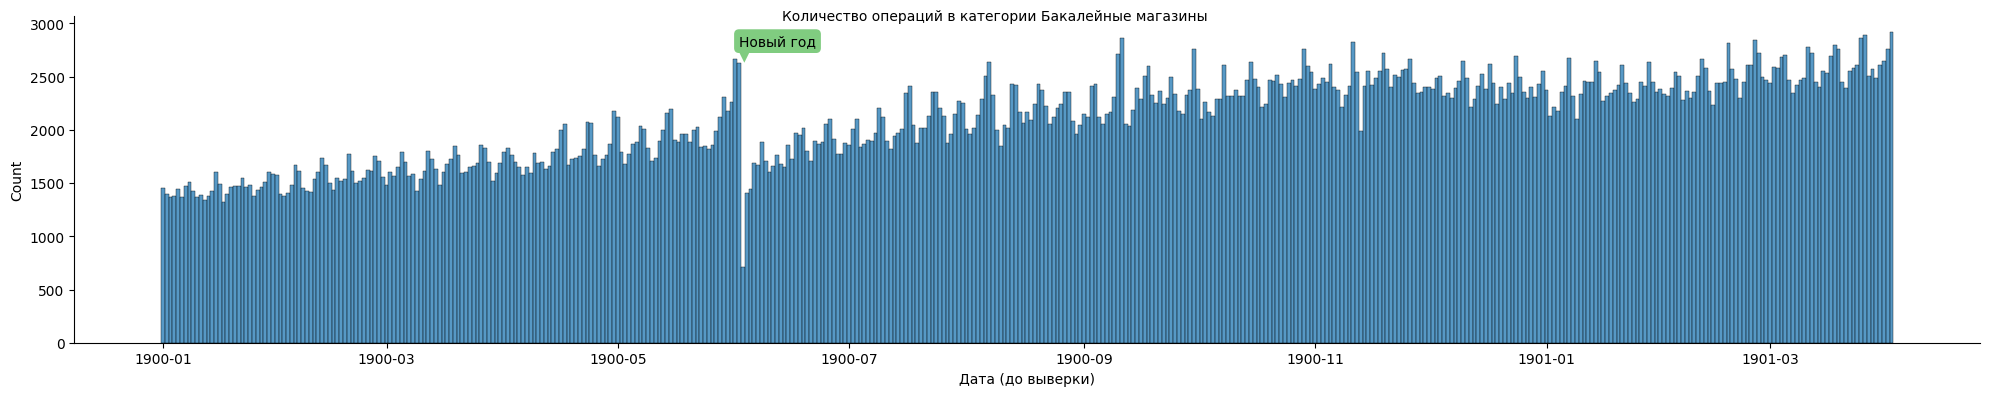

In [18]:
import seaborn as sns


# готовим функцию отрисовки аннотаций
def anno(x, y, text, gender=None):

    if gender == 'f':
        color = (1.0, 0.7, 0.7)
    elif gender == 'm':
        color = (0.5, 0.7, 1.0)
    else:
        color = (0.5, 0.8, 0.5)

    ax.fig.text(x, y, text,  bbox=dict(boxstyle="round",ec=color, fc=color,))
    ax.fig.text(x, y-0.035, "▼", c=color)


# рисуем график 
ax = sns.displot(
    rawset[
        (rawset['mcc_description']=='Бакалейные магазины (5411)')]
        [['tr_date', 'gender']],
    x='tr_date',
    height=4, 
    aspect=5,
)

ax.fig.suptitle('Количество операций в категории Бакалейные магазины', fontsize=10)
ax.set_axis_labels("Дата (до выверки)")
ax.set_titles("Количество операций")

# добавляем отметку с аннотацией
anno(0.372, 0.89, 'Новый год',)

Видим сильное падение количества транзакций в районе 1900-06 - это явно 1 января.

Возьмем более мелкий масштаб и попробуем определить день недели - смапив его с числом, сможем попробовать определить год.

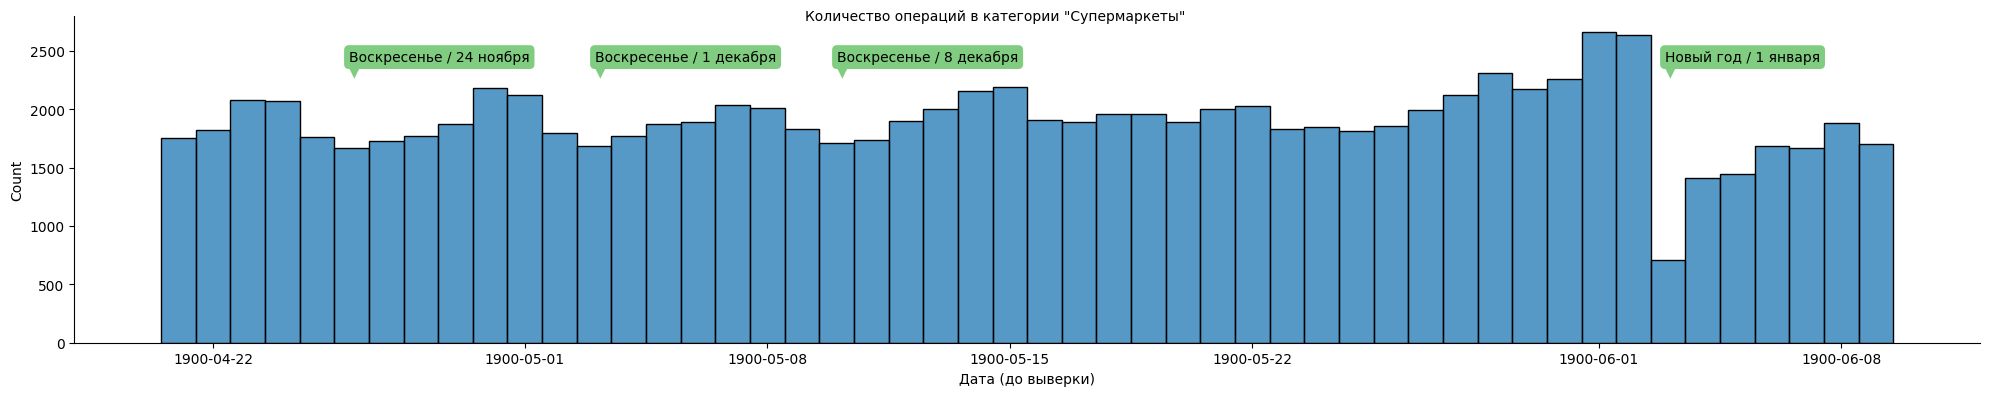

In [19]:
ax = sns.displot(
    rawset[
        (rawset['mcc_description']=='Бакалейные магазины (5411)') 
        & (rawset['tr_date'] > datetime.date(1900,4,20))
        & (rawset['tr_date'] < datetime.date(1900,6,10))
    ][['tr_date', 'gender']],
    x='tr_date',
    height=4, 
    aspect=5,
)

ax.fig.suptitle('Количество операций в категории "Супермаркеты"', fontsize=10)
ax.set_axis_labels("Дата (до выверки)")
ax.set_titles("Количество операций")


# проставляем аннотации
anno(0.835, 0.85, 'Новый год / 1 января',)
anno(0.177, 0.85, 'Воскресенье / 24 ноября',)
anno(0.30, 0.85, 'Воскресенье / 1 декабря',)
anno(0.421, 0.85, 'Воскресенье / 8 декабря',)

Видим, что 1 января соответствует дате 3 июня 1900 года. Но мы пока не знаем год.

Мы видим еженедельные волны, в которых спады доолжны обозначать воскресенье (статистически, понимая, что в этот день большая часть магазинов будет закрыта).

Определим несколько дат, являющихся воскресеньями. Посчитаем какую дату они должны иметь, отсчитывая их от 1го января. Одна из таких дат: 24 ноября. 

Допустим, что 24 ноября в нашем датасете - воскресенье. Попробуем определить год.

In [20]:
for i in range(2010, 2019):
    if datetime.date(i,11,24).isoweekday() == 7:
        print(f'24 ноября было воскресеньем в {i} году')

24 ноября было воскресеньем в 2013 году


Таким образом понимаем, что наша дата 1900-06-01 является вероятнее всего 2014-01-01.

Приводим данные к новому значению. И перестраиваем график.

In [21]:
date_diff = datetime.date(2014,1,1) - datetime.date(1900,6,3)

rawset['tr_datetime'] = rawset['tr_datetime'] + date_diff
rawset['tr_date'] = rawset['tr_datetime'].apply(lambda x: x.date())

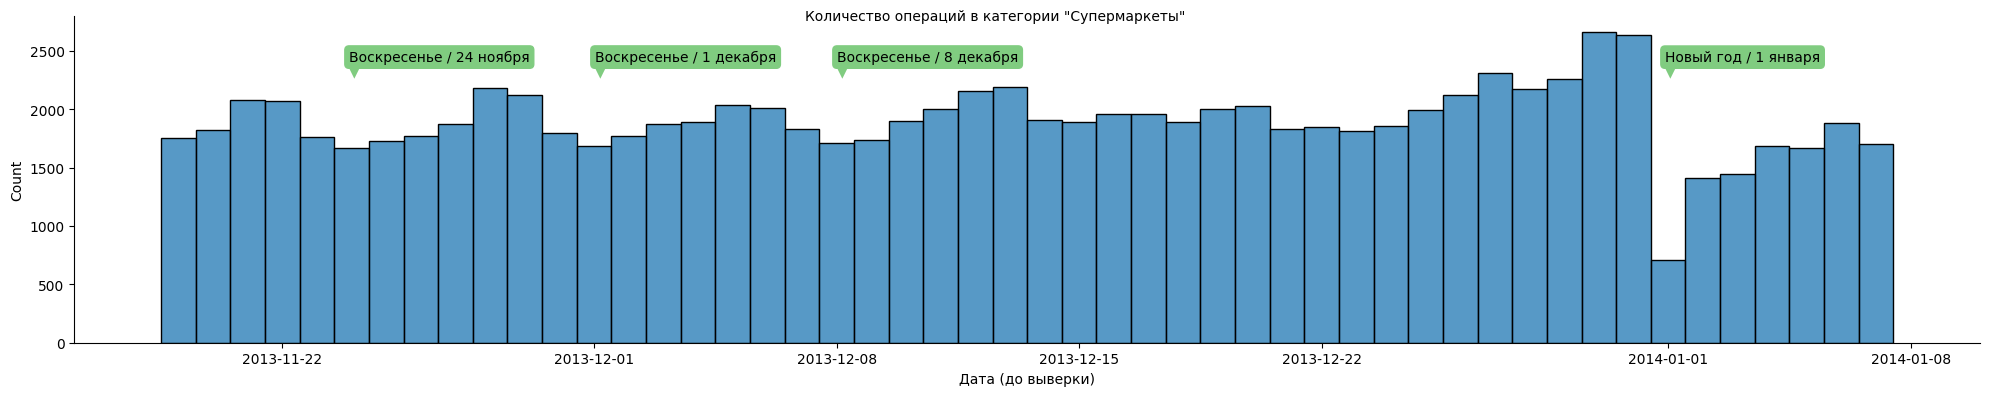

In [22]:
ax = sns.displot(
    rawset[
        (rawset['mcc_description']=='Бакалейные магазины (5411)') 
        & (rawset['tr_date'] > datetime.date(1900,4,20)+date_diff)
        & (rawset['tr_date'] < datetime.date(1900,6,10)+date_diff)
    ][['tr_date', 'gender']],
    x='tr_date',
    height=4, 
    aspect=5,
)

ax.fig.suptitle('Количество операций в категории "Супермаркеты"', fontsize=10)
ax.set_axis_labels("Дата (до выверки)")
ax.set_titles("Количество операций")


# проставляем а
anno(0.835, 0.85, 'Новый год / 1 января',)
anno(0.177, 0.85, 'Воскресенье / 24 ноября',)
anno(0.30, 0.85, 'Воскресенье / 1 декабря',)
anno(0.421, 0.85, 'Воскресенье / 8 декабря',)

Проверим корректность расчета корректных дат на нескольких явно гендерных периодах и отраслях.

Построим график частоты операций в период между днем влюбленных 14 февраля и 8 марта.

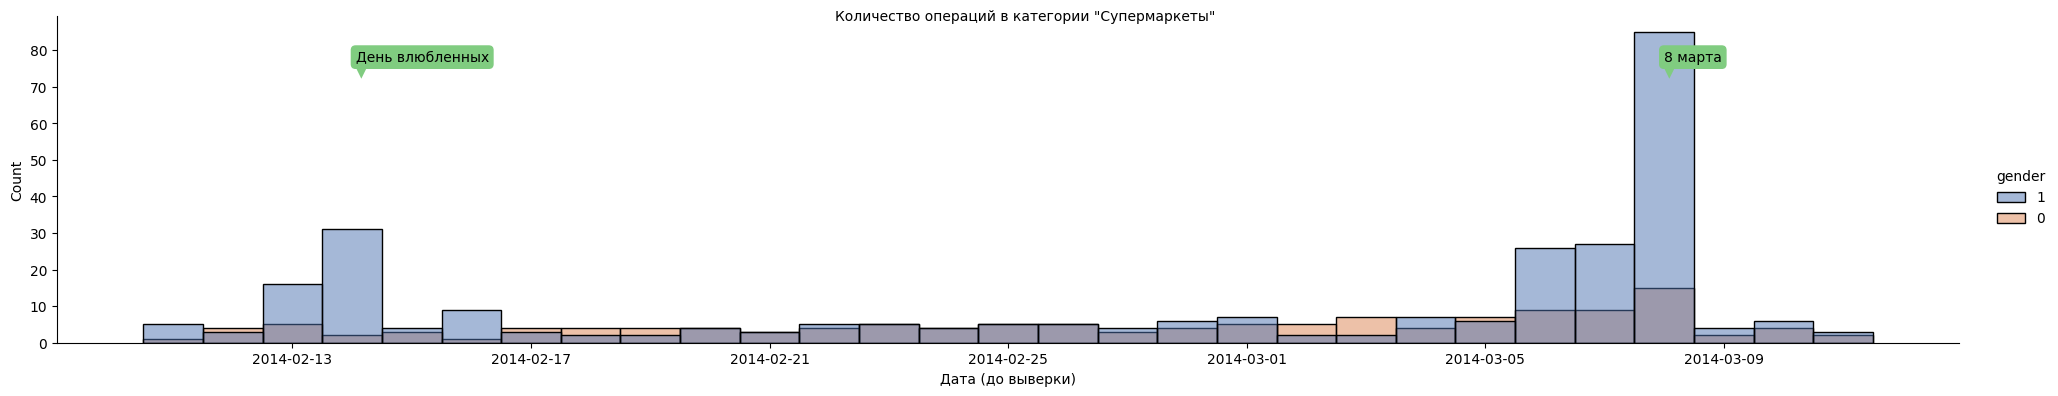

In [23]:
ax = sns.displot(
    rawset[
        (rawset['mcc_description']=='Флористика (5992)') 
        & (rawset['tr_date'] > datetime.date(2014,2,10))
        & (rawset['tr_date'] < datetime.date(2014,3,12))
    ][['tr_date', 'gender']],
    x='tr_date',
    height=4,
    hue='gender', 
    palette='deep',
    hue_order=[1, 0],
    aspect=5,
)

ax.fig.suptitle('Количество операций в категории "Супермаркеты"', fontsize=10)
ax.set_axis_labels("Дата (до выверки)")
ax.set_titles("Количество операций")

anno(0.175, 0.85, 'День влюбленных',)
anno(0.81, 0.85, '8 марта',)

Действительно, 14 февраля и 8 марта ожидаемо получаем пики в количестве транзакций в категории "Флористика" у клиентов-мужчин.

Кстати, мы теперь знаем, что значение 1 в `gender` соответствупт мужским транзакциям, а 0 - женским.

Выделим отдельно поля времени и дня недели для будущей группировки по ним.

In [24]:
rawset['tr_time'] = rawset['tr_datetime'].apply(lambda x: x.time())
rawset['tr_week'] = rawset['tr_datetime'].apply(lambda x: x.isocalendar().week)

Проверяем итоговый сет и сохраняем его в файл для последующего агрегирования в датасет клиентов.

In [25]:
rawset.sample(3, random_state=11)

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,gender,tr_description,device,cash_relation,region,type,mcc_description,mcc_full_description,mcc_group,amount_abs,is_income,tr_date,tr_time,tr_week
4852146,24634142,2014-09-14 16:39:16,5411,1110,-9515.95,25011898,NaN,Покупка. POS ТУ Россия,POS,unrelated,other_bank_trx,POS покупка,Бакалейные магазины (5411),"Бакалейные магазины, супермаркеты",54,9515.95,0.0,2014-09-14,16:39:16,37
3368757,4891744,2014-08-08 19:00:02,5411,1010,-875.91,323492,NaN,Покупка. POS ТУ СБ РФ,POS,unrelated,sberbank_trx,POS покупка,Бакалейные магазины (5411),"Бакалейные магазины, супермаркеты",54,875.91,0.0,2014-08-08,19:00:02,32
6191439,29894123,2014-09-16 11:01:26,6010,7070,49499.98,888987,NaN,Перевод на карту (с карты) через Мобильный банк (без взимания комиссии с отправителя),SMS,unrelated,unrelated,B2C перевод,Финансовые институты (6010),Финансовые институты — снятие наличности вручную,60,49499.98,1.0,2014-09-16,11:01:26,38


Сохраняем данные в файл для дальнейшей работы с ним.

In [26]:
rawset.to_pickle('datasets/formatted_set.pkl')